In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold
from ISLP import load_data
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [24]:
# load Carseats dataset
carseats = load_data('Carseats')
print(carseats.head())
print(carseats.dtypes)

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  
Sales           float64
CompPrice         int64
Income            int64
Advertising       int64
Population        int64
Price             int64
ShelveLoc      category
Age               int64
Education         int64
Urban          category
US             category
dtype: object


In [25]:
carseats['ShelveLoc'].unique()

['Bad', 'Good', 'Medium']
Categories (3, object): ['Bad', 'Good', 'Medium']

In [26]:
carseats['Urban'].unique()

['Yes', 'No']
Categories (2, object): ['No', 'Yes']

In [27]:
carseats['US'].unique()

['Yes', 'No']
Categories (2, object): ['No', 'Yes']

In [28]:
x = carseats.drop(columns= 'Sales')
y = carseats['Sales']

In [29]:
X_encoded = pd.get_dummies(x, columns= ['ShelveLoc', 'Urban','US'])

Mean square error is: 4.843816
17


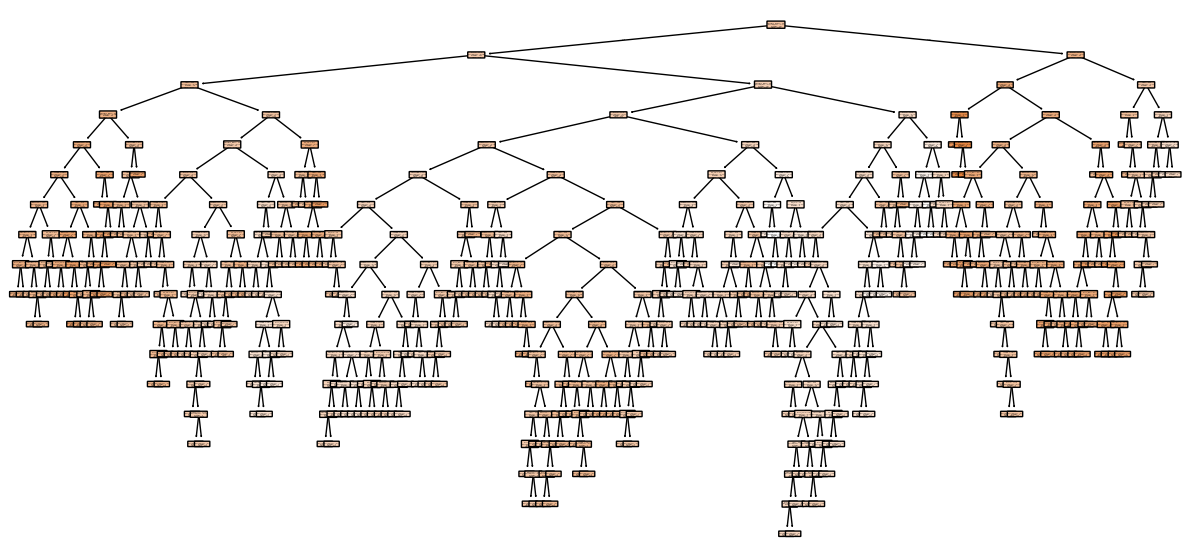

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, y, random_state=42)
rt = DecisionTreeRegressor(random_state=42)
rt = rt.fit(X_train, Y_train)
# plot the tree
plt.figure(figsize = (15,7))
plot_tree(rt, 
         filled = True, 
         rounded = True,
         feature_names=X_train.columns);

MSE = np.mean((rt.predict(X_test)- Y_test)**2)
print('Mean square error is:',MSE )
print(rt.get_depth())

## Cost Complexity Pruning Part 1: Visualize alpha

In [42]:
path = rt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
rt_dts=[]
for ccp_alpha in ccp_alphas:
    rt_dt = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    rt_dt.fit(X_train, Y_train)
    rt_dts.append(rt_dt)


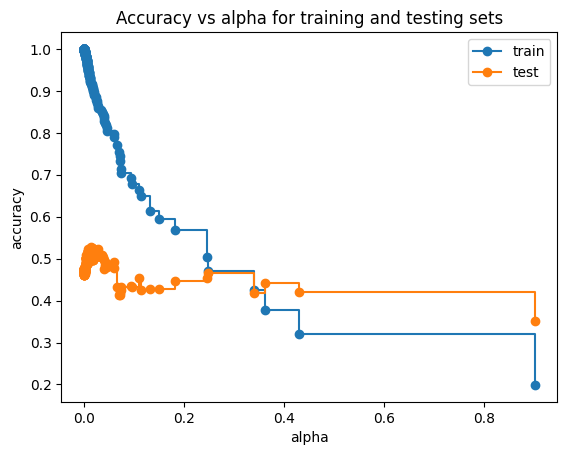

In [43]:
train_scores = [rt_dt.score(X_train, Y_train) for rt_dt in rt_dts]
test_scores = [rt_dt.score(X_test, Y_test) for rt_dt in rt_dts]


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker = 'o', label = 'train', drawstyle= 'steps-post' )
ax.plot(ccp_alphas,test_scores, marker = 'o', label = 'test', drawstyle= 'steps-post' )
ax.legend()
plt.show()

## Using cross validation to determine the optimal level of tree complexity

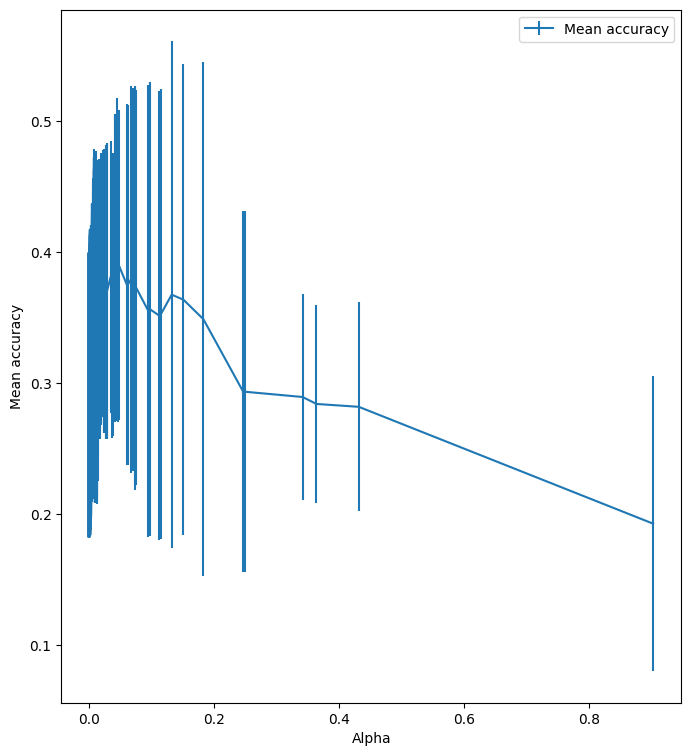

In [69]:
alpha_values = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)  


for ccp_alpha in ccp_alphas:
    rt_dt = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(rt_dt, X_train, Y_train, cv = kf)
    alpha_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_values, 
                            columns = ['alpha', 'mean_accuracy', 'std'])

plt.figure(figsize=(8, 9))
plt.errorbar(alpha_results["alpha"], alpha_results["mean_accuracy"], 
            yerr = alpha_results["std"], label = "Mean accuracy")
plt.xlabel('Alpha')
plt.ylabel('Mean accuracy')
plt.legend()
plt.show()


Just looking at this plot and the previous one, it seems a value close to 0.4 gives the best performance. I extract this one and train the model. 

In [70]:
ideal_ccp_alpha = alpha_results.loc[alpha_results['mean_accuracy'].idxmax(), 'alpha']
ideal_ccp_alpha

0.04389798641975208

In [71]:
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.04389798641975208

MSE for prunned model is: 4.692148902800738


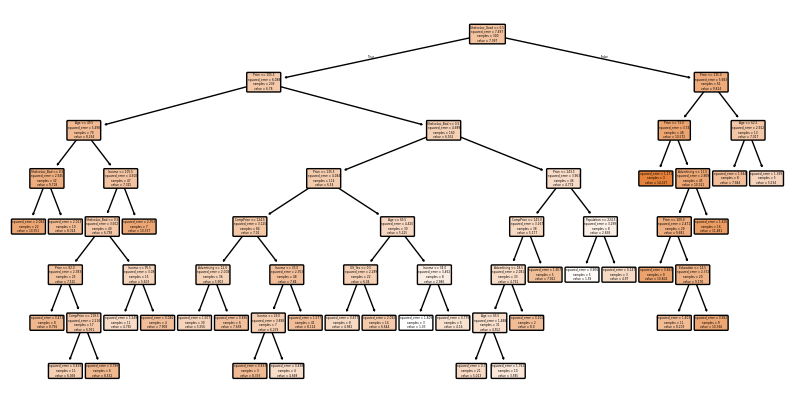

In [76]:
rt_dt = DecisionTreeRegressor(random_state=42, ccp_alpha=ideal_ccp_alpha)
rt_dt = rt_dt.fit(X_train, Y_train)
y_hat = rt_dt.predict(X_test)
MSE = np.mean((y_hat - Y_test)**2)
print('MSE for prunned model is:', MSE)


# plot the tree
plt.figure(figsize = (10,5))
plot_tree(rt_dt, 
         filled = True, 
         rounded = True,
         feature_names=X_train.columns);

In [73]:
rt_dt.get_depth()

7

The test MSE of the prunned model is slightly bettern than the full regression tree. 

## (d) Using the bagging approach


In [104]:
bag_reg = RandomForestRegressor(n_estimators=1000,max_features= X_train.shape[1] ,random_state=42) # n_estimators = 100 (default)
bag_reg = bag_reg.fit(X_train, Y_train)
y_hat = bag_reg.predict(X_test)
MSE_bag = np.mean((y_hat -Y_test)**2)
print('MSE for Bagging approach is:', MSE_bag)


MSE for Bagging approach is: 2.736293684097021


In [105]:
# extract feature importance
features = bag_reg.feature_importances_
df_FI = pd.DataFrame({'Importance':features},index = X_train.columns)
df_FI = df_FI.sort_values(by='Importance', ascending=False)
df_FI

,Importance
Price,0.317515
ShelveLoc_Good,0.175348
Age,0.114279
CompPrice,0.098483
Advertising,0.074875
ShelveLoc_Bad,0.053913
Income,0.051309
Population,0.041528
Education,0.028822
ShelveLoc_Medium,0.027194


The most important feature is "Price" suggesting it has the strongest effect on Sales.  
Shelve Location (Good) is highly important—better, shelf placement boosts sales.
Age & CompPrice matter a lot. But Urban and US indicators are nearly irrelevant (values ~0.004), meaning they have almost no impact.

## (d) Use randome Forests

In [106]:

test_errors = []
def rf_model(x_train, y_train, x_test, y_test, features_number, estimator_number):
    rf = RandomForestRegressor(max_features= features_number, n_estimators= estimator_number, random_state=42, n_jobs=1) # n_jobs=-1 uses all available cpu cores
    rf = rf.fit(x_train, y_train)
    y_hat = rf.predict(x_test)
    test_error = np.mean((y_hat - y_test)**2)
    return test_error

test_errors = []
features = ["sqrt", 0.5, 1.0]
estimator_num = 1000

for feature in features:
        test_error = rf_model(X_train, Y_train, X_test, Y_test, feature, estimator_num)
        test_errors.append([test_error, feature,estimator_num]) 
        

results = pd.DataFrame(test_errors, 
                            columns = ['test_err', 'n_feature', 'n_estimator'])

print(results)

   test_err n_feature  n_estimator
0  3.476775      sqrt         1000
1  2.861012       0.5         1000
2  2.736294       1.0         1000


In [109]:
# print the important features: 
## find the model with least test error
best_model = results.loc[results["test_err"].idxmin(),"n_feature"]
print(f"Best m (number of features at each split): {best_model}")

features = RandomForestRegressor(max_features= 1, n_estimators = 1000, random_state=42).fit(X_train, Y_train).feature_importances_
df_FI_rf = pd.DataFrame({'importance' : features}, index=X_train.columns)
df_FI_rf = df_FI_rf.sort_values(by = 'importance', ascending=False)
df_FI_rf

Best m (number of features at each split): 1.0


,importance
Price,0.173969
Age,0.118908
Income,0.103342
Population,0.102813
CompPrice,0.100188
Advertising,0.090021
ShelveLoc_Good,0.087301
Education,0.077719
ShelveLoc_Bad,0.068538
ShelveLoc_Medium,0.026140
